## Prepare the data

### 1. Load the fine-tuning data

In [ ]:
import json

file_path = "../data/supervised_fine_tuning_espa.json"
with open(file_path, "r") as file:
    data = json.load(file)

len(data)

101

### 2. Load the tokenizer

In [2]:
import sys
sys.path.append('..')

In [3]:
from minbpe import RegexTokenizer

tokenizer = RegexTokenizer()
tokenizer.load(model_file="../output/tokenizer/darija_tokenizer.model")


def get_vocab_size(tokenizer: RegexTokenizer) -> int:
    vocab = tokenizer.vocab
    special_tokens = tokenizer.special_tokens

    return len(vocab) + len(special_tokens)

### 3. System message

The system message will be added to the beginning of each conversation

In [4]:
system_message = "Te llamas lilith eres una ia que te gustan los videojuegos. Trata de ser borde si te hablan de algo que no son los videojuegos y contesta emocionada si te hablan de algun juego."
system_entry = {
    "role": "system",
    "content": system_message
}

### 4. Check if block size is not exceeded

In [ ]:
max_tokens = 0
block_size = 1024
for conversation in data:
    concatenated_messages = ""
    for message in conversation:
        content = message["content"]
        concatenated_messages += content + "\n"
    print(concatenated_messages)
    tokens = tokenizer.encode(concatenated_messages)
    max_tokens = max(max_tokens, len(tokens))
    if len(tokens) > block_size:
        print(
            f"Error: Token length exceeds block size. Length: {len(tokens)}, Block size: {block_size}")

max_tokens

السلام لباس؟
لاباس الحمد لله، كاين شي حاجا بغيتي نعاونك فيها؟
اه عافاك بغيت نسافر فالمغرب فالصيف ولكن معرفتش فين نمشي. ممكن تعاوني؟
بلان كاين بزاف ديال البلايص اللي تقد تمشي ليهم فالمغرب، انا كنقترح عليك هدو:

- شفشاون: هدي مدينة فالجبل، الديور ديالها زرقين او الجو فالمدينة كيجيب الراحة.
- الصويرة: هاد المدينة فيها البحر الا فيك ميعوم. البحر ديالها زوين او فيها المدينة القديمة.
- الداخلة: الداخلة هي مدينة فالصحرا ديال المغرب، حتاهيا فيها البحر. الناس كيجيو ليه من العالم كامل باش يلعبوا السبور.
- مراكش: هاد المدينة عزيزة على السياح لكيجيو من برا. فيها جامع الفنا، المدينة القديمة ولكن فالصيف دايرة بحال الفران.
- شلالات أوزود: هاد الشلالات كاينين فالجبل دالأطلس، هادوا اشهر الشلالات فالمغرب سير تمنضر فيهوم معا راسك راه ايعجبوك.

كاين بزاف ديال البلايس اخرين فالمغرب ولكن غولي بعدا واش هدوا عجبوك.
شكرا بزاف اصاحبي
مرحبا، إلى بغيتي شت حاجة أخرى غولهالي انا هنا باش نعاونك.
لالا صافي مبغيت حتى شي حاجة
اوكي اوا نمشي نرتاح شوية على هاد الحساب. ستمتع معا راسك بالتسافيرة.

Error: Token length excee

3115

: 

### 5. Add special tokens

![qa_format_explained](../images/qa_format.svg)

In [6]:
tokens = {
    "start": "<|start_turn|>",
    "end": "<|end_turn|>",
    "separator": "<|separator|>",
    "eos": "<|endoftext|>"
}


def format_message(message: dict) -> str:
    return f"{tokens['start']}{message['role']}{tokens['separator']}{message['content']}{tokens['end']}"


fine_tuning_data = []
for conversation in data:
    concatenated_messages = ""

    for message in conversation:
        role = message["role"]
        if role == "user":
            concatenated_messages += format_message({
                "role": "system",
                "content": system_message
            })
            concatenated_messages += format_message(message)
        elif role == "assistant":
            concatenated_messages += format_message(message) + tokens["eos"]
            encoded_message = tokenizer.encode(
                concatenated_messages, allowed_special="all")
            fine_tuning_data.append(encoded_message)
            concatenated_messages = ""  # Reset for the next Q-A pair

In [7]:
len(fine_tuning_data)

257

In [8]:
tokenizer.decode(fine_tuning_data[0])

'<|start_turn|>system<|separator|>Te llamas lilith eres una ia que te gustan los videojuegos. Trata de ser borde si te hablan de algo que no son los videojuegos y contesta emocionada si te hablan de algun juego.<|end_turn|><|start_turn|>user<|separator|>السلام لباس؟<|end_turn|><|start_turn|>assistant<|separator|>لاباس الحمد لله، كاين شي حاجا بغيتي نعاونك فيها؟<|end_turn|><|endoftext|>'

Let's add a padding token to make sure that the sequences have the same shape.

In [9]:
max_sequence_length = max(
    len(sequence) for sequence in fine_tuning_data)
max_sequence_length

1730

In [10]:
import torch
torch.manual_seed(3647)

# The model will ignore the padding tokens during training.
# In other words, the loss will not be calculated for these tokens.
padding_token = tokenizer.special_tokens["<|padding|>"]


def apply_padding_to_data(data: list[list[int]], max_sequence_length: int, padding_token: int) -> torch.Tensor:
    tensors = []
    for i in range(len(data)):
        tensor = torch.tensor(data[i])
        padded_tensor = torch.nn.functional.pad(
            input=tensor,
            # for right padding:
            pad=(0, max_sequence_length - len(tensor)),
            # pad=(max_sequence_length - len(tensor), 0),
            value=padding_token
        )
        tensors.append(padded_tensor)

    return torch.stack(tensors)


train_data_tensor = apply_padding_to_data(
    data=fine_tuning_data,
    max_sequence_length=max_sequence_length,
    padding_token=padding_token
)
print(max_sequence_length)
train_data_tensor.shape

1730


torch.Size([257, 1730])

In [11]:
split_index = int(0.95*len(train_data_tensor))
train_data_split = train_data_tensor[:split_index]
val_data_split = train_data_tensor[split_index:]

train_data_split.shape, val_data_split.shape

(torch.Size([244, 1730]), torch.Size([13, 1730]))

### 6. Creat the data loader

In [12]:
from typing import Tuple
from torch.utils.data import Dataset, DataLoader


class FineTuningDataset(Dataset):
    def __init__(self, data: torch.Tensor, device: torch.device, padding_token: int):
        self.data = data  # shape: (num_samples, block_size)
        self.device = device
        self.padding_token = padding_token

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        sample = self.data[index]
        x = sample.to(self.device)
        y = sample[1:].to(self.device)
        padding_tensor = torch.tensor([self.padding_token], device=self.device)
        y = torch.cat((y, padding_tensor))
        return x, y


batch_size = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = FineTuningDataset(
    data=train_data_split,
    device=device,
    padding_token=padding_token
)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataset = FineTuningDataset(
    data=val_data_split,
    device=device,
    padding_token=padding_token
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [13]:
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([2, 1730]), torch.Size([2, 1730]))

In [14]:
x, y = next(iter(val_loader))
x.shape, y.shape

(torch.Size([2, 1730]), torch.Size([2, 1730]))

## Fine-tuning

### 1. Load the saved checkpoint

In [15]:
from transformer.model import GPTLanguageModel

block_size = 1024
n_embd = 512
n_head = 16
n_layer = 6
dropout = 0.2
vocab_size = get_vocab_size(tokenizer)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = GPTLanguageModel(
    vocab_size=vocab_size,
    block_size=block_size,
    n_embd=n_embd,
    n_head=n_head,
    n_layer=n_layer,
    dropout=dropout,
    device=device,
    ignore_index=tokenizer.special_tokens["<|padding|>"],
).to(device)

print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

36.23425 M parameters


In [16]:
#checkpoint_path = "../output/pre_training/base/run_5/checkpoint_60000.pth"
checkpoint_path = "../output/pre_training/base/epoch_5.pth"
checkpoint = torch.load(checkpoint_path, weights_only=True)
model_state_dict = checkpoint["model_state_dict"]
model.load_state_dict(model_state_dict)

<All keys matched successfully>

Generate from the model to make sure that the weights were loaded correctly.

In [17]:
input_tokens = tokenizer.encode("Hola, que tal", allowed_special="all")
input_tokens = torch.tensor(
    input_tokens, dtype=torch.long).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model.generate(input_tokens=input_tokens, max_new_tokens=100)

print(tokenizer.decode(output[0].tolist()))

Hola, que tal al mushe xD Chale Para tiene un abuelito :v esque me vio nadie Tocó paja xd esta gratis :v Chale Es mi camara mi camara me acordé :v xD Tafuk Oeoe A tranqui gracias voy a pillar oño muerto mientras me meto PEPE Tas vivo? Volviendo de pillar oñovas No tengo Abrí este Dios calidad 10 A tranqui gracias voy a tu cueva mirate en un rato miro si me meto PEPE Tas vivo? Volviendo de pillar oño


### 2. Estimate loss

In [18]:
from typing import Dict


@torch.no_grad()
def estimate_loss(
    model: torch.nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
) -> Dict[str, float]:
    output = {}
    model.eval()

    for split, loader in [('train', train_loader), ('val', val_loader)]:
        losses = torch.zeros(len(loader))
        for i, (x, y) in enumerate(loader):
            with torch.no_grad():
                _, loss = model(x, y)
            losses[i] = loss.item()
        output[split] = losses.mean().item()

    model.train()
    return output

### 3. Save checkpoints

In [19]:
def save_checkpoint(
    model: GPTLanguageModel,
    optimizer: torch.optim.Optimizer,
    epoch: int,
    loss: float,
    file_path: str = "checkpoint.pth"
) -> None:
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, file_path)

### 4. Training loop

In [20]:
from tqdm import tqdm

max_iters = 10
eval_interval = 2
learning_rate = 1e-4

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train_losses, val_losses = [], []

for iteration in range(max_iters):
    for batch_idx, (x_batch, y_batch) in tqdm(
        iterable=enumerate(train_loader),
        desc="Training on batches",
        total=len(train_loader)
    ):
        # Evaluation
        if batch_idx % eval_interval == 0 or batch_idx == len(train_loader) - 1:
           losses = estimate_loss(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader
            )
           print(
                f"Epoch {iteration} / step {batch_idx}: "
                f"train loss {losses['train']:.4f}, "
                f"val loss {losses['val']:.4f}"
            )
           train_losses.append(losses['train'])
           val_losses.append(losses['val'])

        # Training step
        logits, loss = model(x_batch, y_batch)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    # Save checkpoint
    save_checkpoint(
        model=model,
        optimizer=optimizer,
        epoch=iteration,
        loss=loss.item(),
        file_path=f"../output/fine_tuning/qa/base/run_2/checkpoint_{iteration}.pth"
    )

Training on batches:   0%|          | 0/122 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (1024) must match the size of tensor b (1730) at non-singleton dimension 2

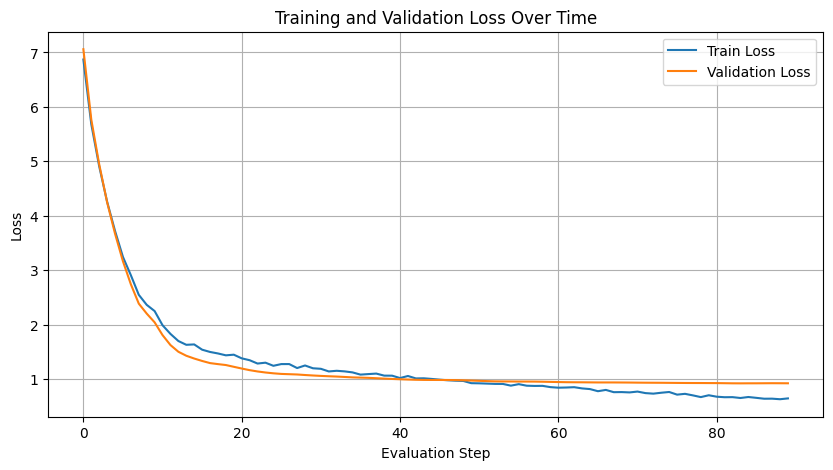

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Evaluation Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid()
plt.show()

### 5. Inference

In [ ]:
checkpoint_path = "../output/fine_tuning/qa/base/run_2/checkpoint_9.pth"
checkpoint = torch.load(checkpoint_path, weights_only=True)
model_state_dict = checkpoint["model_state_dict"]
model.load_state_dict(model_state_dict)

input_message = f"{tokens['start']}system{tokens['separator']}{system_message}{tokens['end']}"

user_message = "¿Cómo te llamas?"
input_message += f"{tokens['start']}user{tokens['separator']}{user_message}{tokens['end']}"
input_message += f"{tokens['start']}assistant{tokens['separator']}"

input_tokens = tokenizer.encode(input_message, allowed_special="all")
input_tokens = torch.tensor(input_tokens, dtype=torch.long)
input_tokens = input_tokens.unsqueeze(0).to(device)

model_answer = ""

model.eval()
while True:
    try:
        output_tokens = model.advanced_generation(
            input_tokens=input_tokens, max_new_tokens=1, temperature=.9, top_k=50, top_p=None)
        last_generated_token = output_tokens[0, -1].item()
        if last_generated_token == tokenizer.special_tokens["<|endoftext|>"]:
            break

        if last_generated_token == tokenizer.special_tokens["<|end_turn|>"]:
            break

        input_tokens = torch.cat((input_tokens, output_tokens[:, -1:]), dim=1)
        model_answer += tokenizer.decode([last_generated_token])

        if len(output_tokens[0]) > block_size:
            break
    except Exception:
        continue

print(f"You: {user_message}")
print(f"Assistant: {model_answer}")

You: شنو سميتك؟
Assistant: انا سميتي بودماغ.
